In [1]:
import phate

In [2]:
%load_ext autoreload
%autoreload 2
import tphate, mds
import statsmodels.api as sm
import numpy as np
import time
import mds
import matplotlib.pyplot as plt


In [3]:
# Generate random autocorrelative data
def f(x, a, sigma):
    noisy = a*x + np.random.normal(0.0, sigma, size=x.shape)
    return noisy

features, samples=100,80
X = np.ones((features, samples))*np.arange(samples)
Ys = np.array([f(x, 2, 10) for x in X]).T # want samples x features input (timepoints by voxels)
Ys.shape

(80, 100)

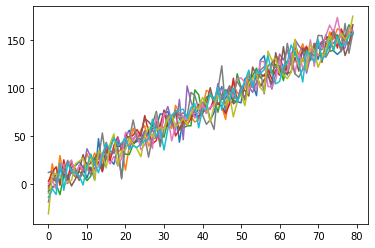

In [9]:
# plot data
_=plt.plot(Ys[:,::10])

None 40 4


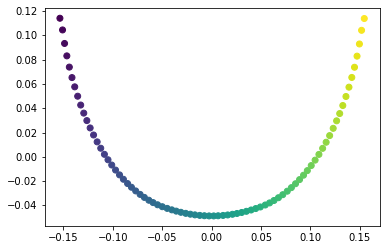

In [12]:
# Embed with tphate
tphate_op = tphate.TPHATE(n_jobs=-1, verbose=0, t=5, mds='metric', mds_solver='sgd',smooth_window=4)
embedding = tphate_op.fit_transform(Ys)
plt.scatter(embedding[:,0], embedding[:,1], c=np.arange(80))

In [13]:
tphate_op.dropoff

30

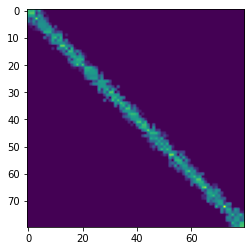

In [11]:
# Plot the PHATE diffusion operator
plt.imshow(tphate_op.phate_diffop)

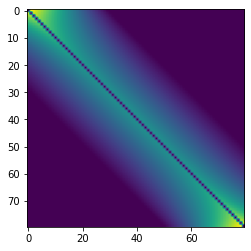

In [12]:
# plot the autocorrelation kernel
plt.imshow(tphate_op.autocorr_op)

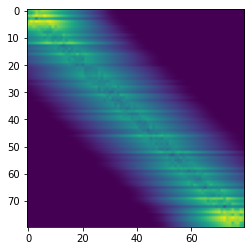

In [13]:
# Plot the combined TPHATE diffusion op
plt.imshow(tphate_op.diff_op)

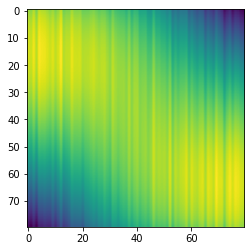

In [18]:
plt.imshow(tphate_op._diff_potential)

In [14]:
## Functions from before prepackaging.

def generate_fixed_autocorrelation_view(data, smooth_window=1):
    """ 
    Generates a diffusion operator based on the calculated autocorrelation function 
    of the input data (as smoothed over smooth_window).

    Parameters:
    data: numpy array of [n_timepoints, n_voxels]
    smooth_window: int, used for convolving the autocorrelation function in a rolling avg

    Output:
    M : numpy array of [n_timepoints, n_timepoints] symmetric matrix of row-normalized 
    fixed autocorrelation function
    """
    A_vox = np.empty_like(data) # placeholder for the autocorr functions of each voxel
    n_timepoints, n_voxels = data.shape

    # compute autocorr function independently for each voxel, then average over voxels 
    # (more stable than the reverse)
    for v in range(n_voxels):
        x = data[:, v]
        A_vox[:, v] = sm.tsa.acf(x, fft=False, nlags=len(x)-1) # calculate all possible lags 
    A_avg = np.mean(A_vox, axis=1)
    y = np.convolve(A_avg, np.ones(smooth_window), 'same') / smooth_window # rolling average
    # get the first point at which the rolling avg drops below zero; consider this the end of the function
    dropoff = np.where(y < 0)[0][0] 

    M = np.zeros((n_timepoints, n_timepoints))
    for i in np.arange(n_timepoints):
        for j in np.arange(n_timepoints):
            if abs(i-j) < dropoff and i != j:
                M[i, j] = y[abs(i-j)]
                M[j, i] = y[abs(i-j)]
    # row normalize
    for row in M:
        if np.sum(row) == 0: # this should never be true
            continue
        row[:] /= np.sum(row)
    return M

def embed_oldtphate(data):
    phate_op=phate.PHATE(verbose=0).fit(data)
    Top=generate_fixed_autocorrelation_view(data)
    P = np.matmul(phate_op.diff_op.T, Top)
    K = np.linalg.matrix_power(P, 5)
    K = np.log(K + 1e-7)
    K = np.nan_to_num(K, nan=0.0).T
    embedding = mds.embed_MDS(K, ndim=2, how='metric', 
                              n_jobs=-1, solver='sgd')
    return embedding,K,Top

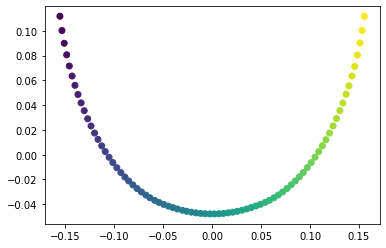

In [15]:
embd,K,Top=embed_oldtphate(Ys)
plt.scatter(embd[:,0], embd[:,1], c=np.arange(embd.shape[0]))

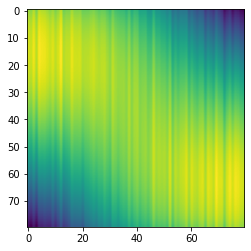

In [16]:
plt.imshow(K) # diffusion potential

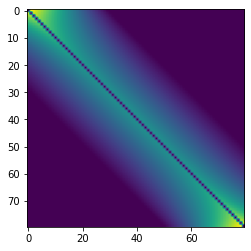

In [17]:
plt.imshow(Top) # ac kernel